# Imports

In [1]:
import zipfile
import os
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

import seaborn as sns

In [2]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

In [3]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

# Download Data

In [4]:
dataset_name = 'spaceship-titanic'

In [5]:
!kaggle competitions download -c 'spaceship-titanic'

spaceship-titanic.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
path_to_zip_file = os.getcwd() + '/' + dataset_name + '.zip'
directory_to_extract_to = os.getcwd() + '/' + dataset_name

In [7]:
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

# Load Data

In [8]:
data = pd.read_csv(directory_to_extract_to + '/train.csv')

# Missing Values

In [33]:
num_vars = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

In [10]:
data[['Deck', 'CabinNumber', 'Side']] = data['Cabin'].str.split('/', expand=True)
data.drop(columns=['Cabin','PassengerId', 'Name'], inplace=True)
data.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,CabinNumber,Side
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,B,0,P
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,F,0,S
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,A,0,S
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,A,0,S
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,F,1,S


In [21]:
data.columns

Index(['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'RoomService',
       'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Transported', 'Deck',
       'CabinNumber', 'Side'],
      dtype='object')

In [34]:
num_vars

['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

In [12]:
cat_vars = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Deck', 'Side']

In [81]:
max_threshold = 0.2
step = 0.001
threshold = 0.024

results_dict = {}
models = {
          'logistic_regression': LogisticRegression(),
          'decision_tree': DecisionTreeClassifier(),
          'naive_bayes': GaussianNB(),
          'svm': make_pipeline(StandardScaler(), SVC(gamma='auto')),
          'gradient_boosting': GradientBoostingClassifier(),
          'random_forest' : RandomForestClassifier(),
          'knn': KNeighborsClassifier()
         }

through = {v: 0 for v in cat_vars}
i = 0
while threshold <= max_threshold:
    #print(f'Threshold {threshold}')
    df_aux = data.copy()
    results_dict[threshold] = {}
    
    for var in cat_vars:
        #print('-- CAT VARS --')
        #print(f'  Variable {var}')
        #print(f'    Q nans {df_aux[var].isna().sum()}')
        perc_nans = df_aux[var].isna().sum()/ len(df_aux[var])
        if perc_nans <= threshold:
            #print('----- MODA ------')
            through[var] = 1
            df_aux[var] = df_aux[var].fillna(df_aux[var].mode()[0])
        else:
            df_aux[var] = df_aux[var].fillna('Missing')
    
    for var in num_vars:
        #print('-- NUM VARS --')
        #print(f'  Variable {var}')
        #print(f'    Q nans {df_aux[var].isna().sum()}')
        perc_nans = df_aux[var].isna().sum()/ len(df_aux[var])
        if perc_nans <= threshold:
            # print('----- MODA ------')
            through[var] = 1
            df_aux[var] = df_aux[var].fillna(df_aux[var].mode()[0])
        
        
    df_aux[cat_vars] = df_aux[cat_vars].astype(str)
    
    ohe = OneHotEncoder(handle_unknown='ignore')
    ohe_data = pd.DataFrame(ohe.fit_transform(df_aux[cat_vars]).toarray())
    
    ohe_data.columns = ohe.get_feature_names_out()    
    df_aux = pd.concat([df_aux, ohe_data], axis=1)
    
    df_aux.drop(columns=cat_vars, inplace=True)
    df_aux = df_aux.dropna()
        
    X = df_aux.drop(columns=['Transported'])
    y = df_aux['Transported']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    
    for model_name, model in models.items():
        model.fit(X_train, y_train)
        acc = model.score(X_test, y_test)
        
        predictions = model.predict(X_test)
        cm = confusion_matrix(y_test, predictions, labels=model.classes_, normalize='true')
        
        results_dict[threshold][model_name] = {'accuracy': acc,
                                'cm': cm}
        
        if ((i == 0) & (model_name ==  'gradient_boosting')):
            saved_model = model
            print(f'ACCURACY {acc}')
    
    flag = True if sum([v for v in through.values()]) == len(cat_vars) + len(num_vars) else False
    if flag:
        threshold = 2
    threshold += step

Threshold 0.024
-- CAT VARS --
  Variable HomePlanet
    Q nans 201
----- MODA ------
-- CAT VARS --
  Variable CryoSleep
    Q nans 217
-- CAT VARS --
  Variable Destination
    Q nans 182
----- MODA ------
-- CAT VARS --
  Variable VIP
    Q nans 203
----- MODA ------
-- CAT VARS --
  Variable Deck
    Q nans 199
----- MODA ------
-- CAT VARS --
  Variable Side
    Q nans 199
----- MODA ------
-- NUM VARS --
  Variable Age
    Q nans 179
----- MODA ------
-- NUM VARS --
  Variable RoomService
    Q nans 181
----- MODA ------
-- NUM VARS --
  Variable FoodCourt
    Q nans 183
----- MODA ------
-- NUM VARS --
  Variable ShoppingMall
    Q nans 208
----- MODA ------
-- NUM VARS --
  Variable Spa
    Q nans 183
----- MODA ------
-- NUM VARS --
  Variable VRDeck
    Q nans 188
----- MODA ------


/Users/juanmanuelcazorla/opt/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ACCURACY 0.8168549905838042
Threshold 0.025
-- CAT VARS --
  Variable HomePlanet
    Q nans 201
----- MODA ------
-- CAT VARS --
  Variable CryoSleep
    Q nans 217
----- MODA ------
-- CAT VARS --
  Variable Destination
    Q nans 182
----- MODA ------
-- CAT VARS --
  Variable VIP
    Q nans 203
----- MODA ------
-- CAT VARS --
  Variable Deck
    Q nans 199
----- MODA ------
-- CAT VARS --
  Variable Side
    Q nans 199
----- MODA ------
-- NUM VARS --
  Variable Age
    Q nans 179
----- MODA ------
-- NUM VARS --
  Variable RoomService
    Q nans 181
----- MODA ------
-- NUM VARS --
  Variable FoodCourt
    Q nans 183
----- MODA ------
-- NUM VARS --
  Variable ShoppingMall
    Q nans 208
----- MODA ------
-- NUM VARS --
  Variable Spa
    Q nans 183
----- MODA ------
-- NUM VARS --
  Variable VRDeck
    Q nans 188
----- MODA ------


/Users/juanmanuelcazorla/opt/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ACCURACY 0.8135593220338984


In [80]:
saved_model

NameError: name 'saved_model' is not defined

In [46]:
results_df = pd.DataFrame(columns=['threshold', 'model', 'accuracy', 'true_accuracy', 'false_accuracy'])

for t, d1 in results_dict.items():
    for m, d2 in d1.items():
        new_row = {'threshold': t,
                    'model': m,
                    'accuracy': d2['accuracy'],
                    'true_accuracy': d2['cm'][1, 1],
                    'false_accuracy': d2['cm'][0, 0]
                  }
        results_df = results_df.append(new_row, ignore_index=True)


/var/folders/n9/0y787lk94bn7vrd7zk8cdkj40000gn/T/ipykernel_13410/58471667.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(new_row, ignore_index=True)
/var/folders/n9/0y787lk94bn7vrd7zk8cdkj40000gn/T/ipykernel_13410/58471667.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(new_row, ignore_index=True)
/var/folders/n9/0y787lk94bn7vrd7zk8cdkj40000gn/T/ipykernel_13410/58471667.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(new_row, ignore_index=True)
/var/folders/n9/0y787lk94bn7vrd7zk8cdkj40000gn/T/ipykernel_13410/58471667.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

In [47]:
results_df[results_df['model'] == 'gradient_boosting']

,threshold,model,accuracy,true_accuracy,false_accuracy
4,0.020,gradient_boosting,0.814616,0.841220,0.786813
11,0.021,gradient_boosting,0.811631,0.841401,0.781893
18,0.022,gradient_boosting,0.802606,0.844633,0.758416
25,0.023,gradient_boosting,0.802606,0.844633,0.758416
32,0.024,gradient_boosting,0.816855,0.858365,0.776119
39,0.025,gradient_boosting,0.813559,0.848859,0.778918


<AxesSubplot:xlabel='threshold', ylabel='accuracy'>

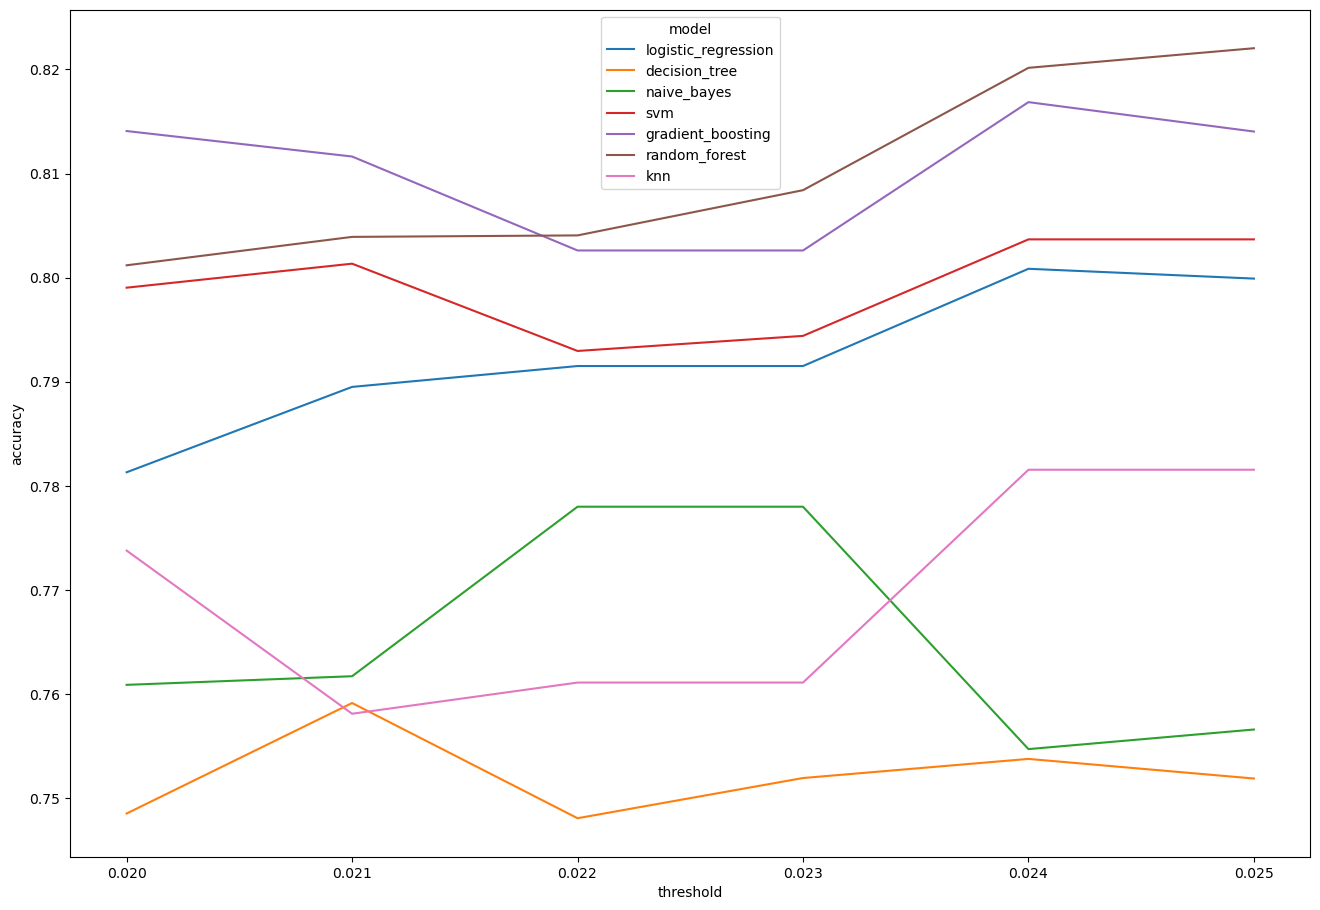

In [40]:
fig, ax = plt.subplots(figsize=(16, 11))
sns.lineplot(data = results_df, hue='model', x='threshold', y='accuracy')

<AxesSubplot:xlabel='threshold', ylabel='false_accuracy'>

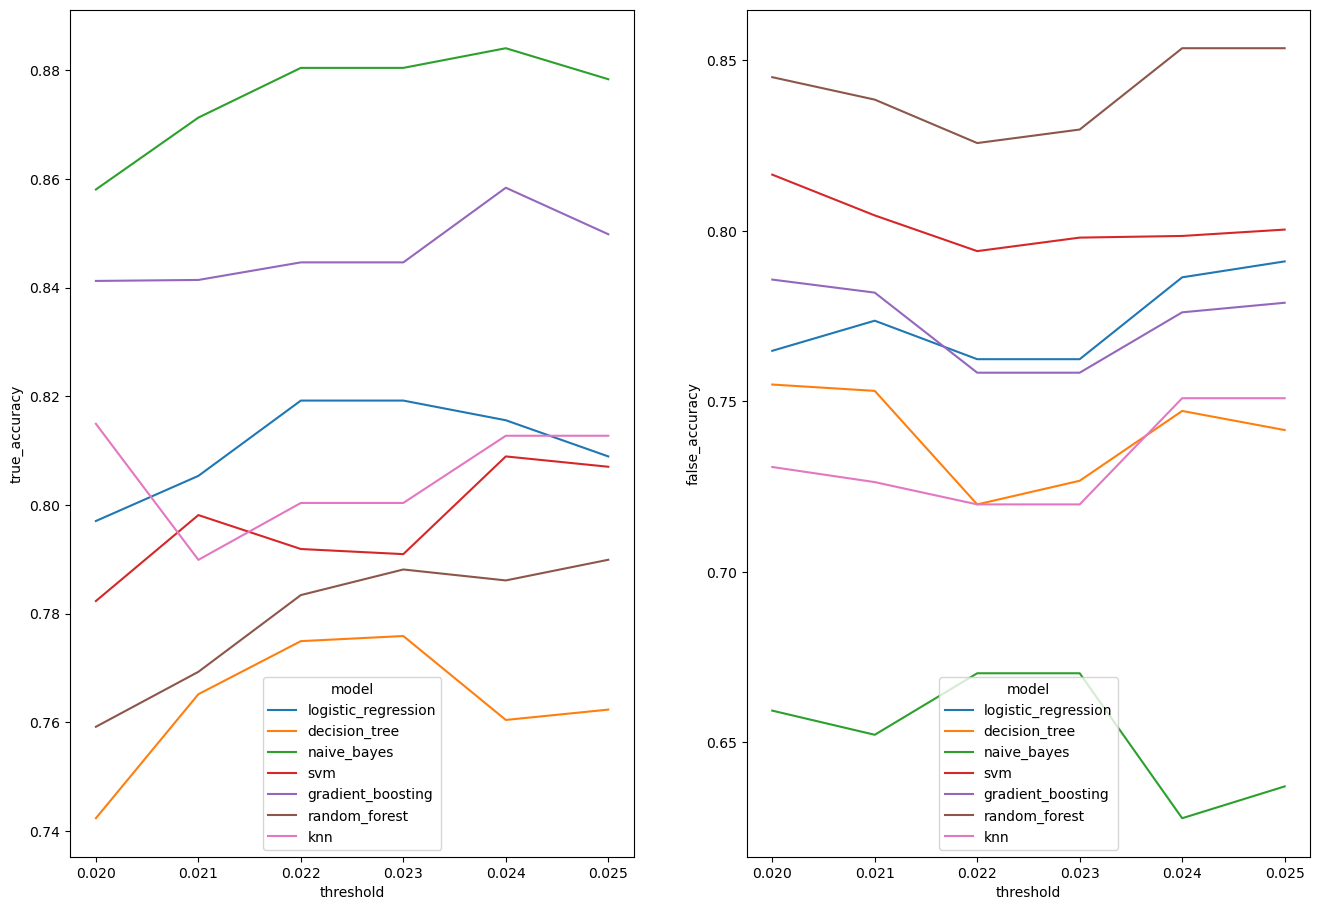

In [42]:
fig, ax = plt.subplots(1, 2, figsize=(16, 11))
sns.lineplot(data = results_df, hue='model', x='threshold', y='true_accuracy', ax=ax[0])
sns.lineplot(data = results_df, hue='model', x='threshold', y='false_accuracy', ax=ax[1])

In [41]:
data.dropna(inplace=True)

<AxesSubplot:>

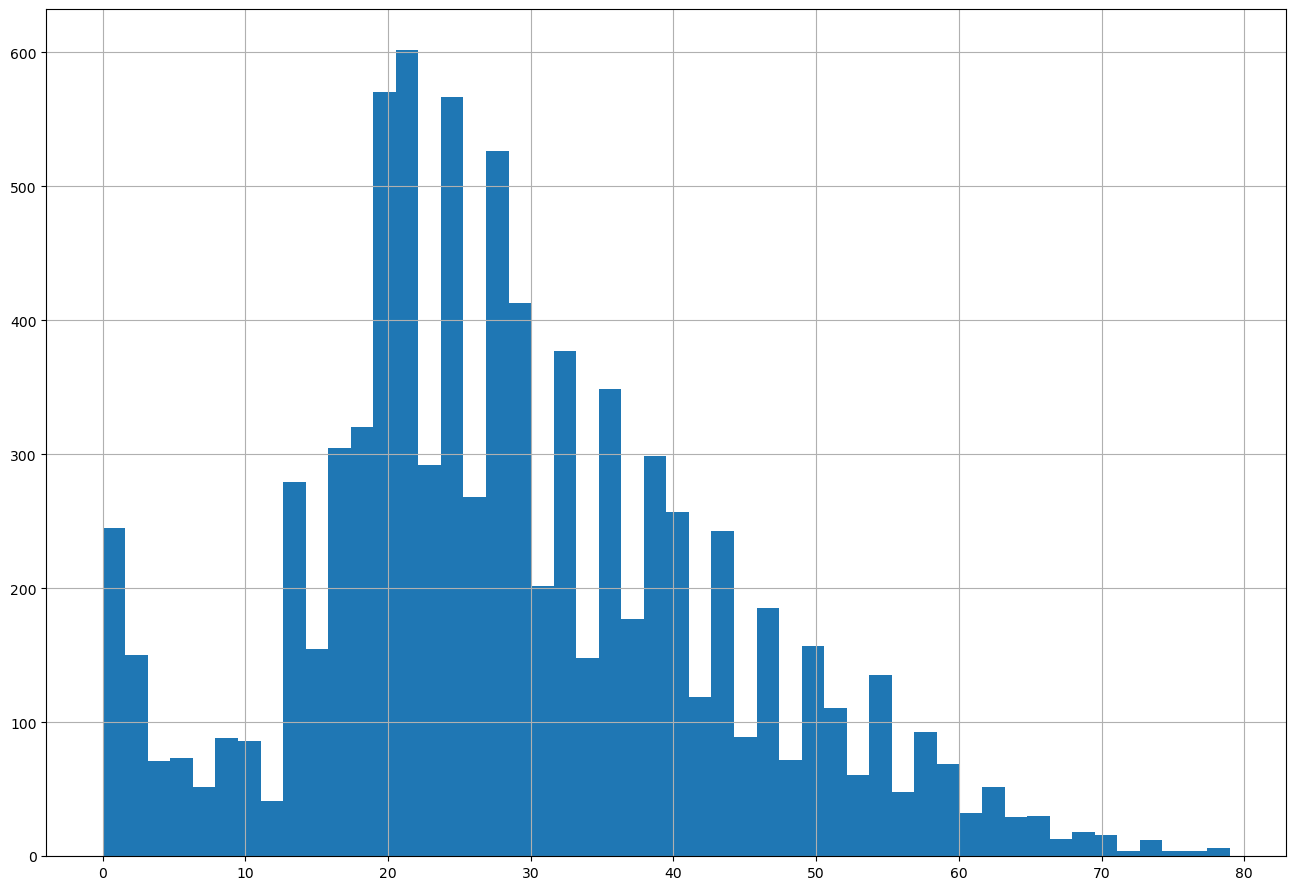

In [55]:
data['Age'].hist(bins = 50, figsize=(16, 11))

In [43]:
data.isna().sum()

HomePlanet      0
CryoSleep       0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Transported     0
Deck            0
CabinNumber     0
Side            0
dtype: int64

In [44]:
data[cat_vars] = data[cat_vars].astype(str)

In [45]:
data.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,CabinNumber,Side
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,B,0,P
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,F,0,S
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,A,0,S
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,A,0,S
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,F,1,S


In [46]:
for v in cat_vars:
    print(data[v].unique())

['Europa' 'Earth' 'Mars' 'Missing']
['False' 'True' 'Missing']
['TRAPPIST-1e' 'PSO J318.5-22' '55 Cancri e' 'Missing']
['False' 'True' 'Missing']
['B' 'F' 'A' 'G' 'E' 'D' 'C' 'T']
['P' 'S']


# One Hot Encoding

In [47]:
ohe = OneHotEncoder(handle_unknown='ignore')
ohe_data = pd.DataFrame(ohe.fit_transform(data[cat_vars]).toarray())
ohe_data.head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [48]:
ohe_data.columns = ohe.get_feature_names_out()

In [49]:
ohe_data

,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,HomePlanet_Missing,CryoSleep_False,CryoSleep_Missing,CryoSleep_True,Destination_55 Cancri e,Destination_Missing,Destination_PSO J318.5-22,...,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_P,Side_S
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7436,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
7437,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
7438,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
7439,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [50]:
data = data.reset_index(drop=True)
data

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,CabinNumber,Side
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,B,0,P
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,F,0,S
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,A,0,S
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,A,0,S
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,F,1,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7436,Europa,False,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,False,A,98,P
7437,Earth,True,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,False,G,1499,S
7438,Earth,False,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,True,G,1500,S
7439,Europa,False,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,False,E,608,S


In [51]:
final_data = pd.concat([data, ohe_data], axis=1)

In [52]:
final_data

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,...,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_P,Side_S
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7436,Europa,False,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
7437,Earth,True,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
7438,Earth,False,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
7439,Europa,False,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [53]:
final_data = final_data.drop(columns=cat_vars)

In [54]:
final_data

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,CabinNumber,HomePlanet_Earth,HomePlanet_Europa,...,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_P,Side_S
0,39.0,0.0,0.0,0.0,0.0,0.0,False,0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,24.0,109.0,9.0,25.0,549.0,44.0,True,0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,58.0,43.0,3576.0,0.0,6715.0,49.0,False,0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,33.0,0.0,1283.0,371.0,3329.0,193.0,False,0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,16.0,303.0,70.0,151.0,565.0,2.0,True,1,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7436,41.0,0.0,6819.0,0.0,1643.0,74.0,False,98,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
7437,18.0,0.0,0.0,0.0,0.0,0.0,False,1499,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
7438,26.0,0.0,0.0,1872.0,1.0,0.0,True,1500,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
7439,32.0,0.0,1049.0,0.0,353.0,3235.0,False,608,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


# Train/Test Split

In [55]:
X = final_data.drop(columns=['Transported'])
y = final_data['Transported']

In [56]:
X.head()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,CabinNumber,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,...,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_P,Side_S
0,39.0,0.0,0.0,0.0,0.0,0.0,0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,24.0,109.0,9.0,25.0,549.0,44.0,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,58.0,43.0,3576.0,0.0,6715.0,49.0,0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,33.0,0.0,1283.0,371.0,3329.0,193.0,0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,16.0,303.0,70.0,151.0,565.0,2.0,1,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [57]:
y.head()

0    False
1     True
2    False
3    False
4     True
Name: Transported, dtype: bool

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Simple Logistic Regression

In [17]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression

In [60]:
clf = LogisticRegression(random_state=0).fit(X_train, y_train)

/Users/juanmanuelcazorla/opt/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [61]:
clf.score(X_test, y_test)

0.7807630306286942

In [8]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

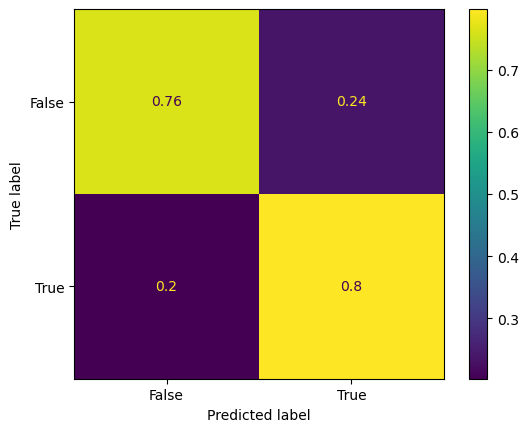

In [63]:
predictions = clf.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=clf.classes_, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

# SimpleDecision Tree

In [11]:
from sklearn.tree import DecisionTreeClassifier

In [65]:
dtc = DecisionTreeClassifier()
dtc = dtc.fit(X_train, y_train)
dtc.score(X_test, y_test)

0.7479849543256314

# Simple Naive Bayes

In [10]:
from sklearn.naive_bayes import GaussianNB

In [67]:
gnb = GaussianNB()
gnb = gnb.fit(X_train, y_train)
gnb.score(X_test, y_test)

0.7608812466415905

# Simple SVM

In [12]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [69]:
svm = make_pipeline(StandardScaler(), SVC(gamma='auto'))
svm = svm.fit(X_train, y_train)
svm.score(X_test, y_test)

0.7979580870499732

# Simple Gradient Boosting

In [13]:
from sklearn.ensemble import GradientBoostingClassifier

In [71]:
gb = GradientBoostingClassifier()
gb = gb.fit(X_train, y_train)
gb.score(X_test, y_test)

0.814615797958087

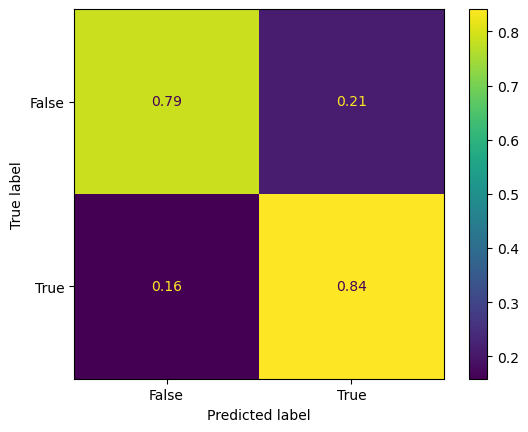

In [72]:
predictions = gb.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=clf.classes_, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

# Simple Random Forest

In [14]:
from sklearn.ensemble import RandomForestClassifier

In [74]:
rf = RandomForestClassifier()
rf = rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.7936593229446535

# Simple KNN

In [15]:
from sklearn.neighbors import KNeighborsClassifier

In [76]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
knn.score(X_test, y_test)

0.7743148844707146

# Load Test Data

In [88]:
test_data = pd.read_csv(directory_to_extract_to + '/test.csv')

# Missing Values

In [89]:
test_data[['Deck', 'CabinNumber', 'Side']] = test_data['Cabin'].str.split('/', expand=True)
test_data.drop(columns=['Cabin','PassengerId', 'Name'], inplace=True)
test_data.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Deck,CabinNumber,Side
0,Earth,True,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,G,3,S
1,Earth,False,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,F,4,S
2,Europa,True,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,C,0,S
3,Europa,False,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,C,1,S
4,Earth,False,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,F,5,S


In [90]:
th = 0.024

num_vars.append('CabinNumber')
for var in cat_vars:
    perc = test_data[var].isna().sum() / len(test_data[var])
    if perc <= th:
        test_data[var] = test_data[var].fillna(test_data[var].mode()[0])
    else:
        test_data[var] = test_data[var].fillna('Missing')
for var in num_vars:
    test_data[var] = test_data[var].fillna(test_data[var].mode()[0])

    

In [91]:
test_data.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Deck,CabinNumber,Side
0,Earth,True,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,G,3,S
1,Earth,False,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,F,4,S
2,Europa,True,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,C,0,S
3,Europa,False,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,C,1,S
4,Earth,False,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,F,5,S


In [92]:
test_data.isna().sum()

HomePlanet      0
CryoSleep       0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Deck            0
CabinNumber     0
Side            0
dtype: int64

In [93]:
test_data[cat_vars] = test_data[cat_vars].astype(str)

In [94]:
test_data.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Deck,CabinNumber,Side
0,Earth,True,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,G,3,S
1,Earth,False,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,F,4,S
2,Europa,True,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,C,0,S
3,Europa,False,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,C,1,S
4,Earth,False,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,F,5,S


In [95]:
for v in cat_vars:
    print(test_data[v].unique())

['Earth' 'Europa' 'Mars']
['True' 'False']
['TRAPPIST-1e' '55 Cancri e' 'PSO J318.5-22']
['False' 'True']
['G' 'F' 'C' 'B' 'D' 'E' 'A' 'T']
['S' 'P']


# One Hot Encoding

In [96]:
ohe_test_data = pd.DataFrame(ohe.transform(test_data[cat_vars]).toarray())
ohe_test_data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [97]:
ohe_test_data.columns = ohe.get_feature_names_out()

In [98]:
ohe_test_data

,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,CryoSleep_False,CryoSleep_True,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,VIP_False,VIP_True,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_P,Side_S
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4273,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4274,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4275,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [99]:
test_data = test_data.reset_index(drop=True)
test_data

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Deck,CabinNumber,Side
0,Earth,True,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,G,3,S
1,Earth,False,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,F,4,S
2,Europa,True,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,C,0,S
3,Europa,False,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,C,1,S
4,Earth,False,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,F,5,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,Earth,True,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,G,1496,S
4273,Earth,False,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,F,4,S
4274,Mars,True,55 Cancri e,18.0,False,0.0,0.0,0.0,0.0,0.0,D,296,P
4275,Europa,False,TRAPPIST-1e,18.0,False,0.0,2680.0,0.0,0.0,523.0,D,297,P


In [100]:
final_test_data = pd.concat([test_data, ohe_test_data], axis=1)

In [101]:
final_test_data

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,...,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_P,Side_S
0,Earth,True,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,Earth,False,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,Europa,True,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,Europa,False,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,Earth,False,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,Earth,True,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4273,Earth,False,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4274,Mars,True,55 Cancri e,18.0,False,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4275,Europa,False,TRAPPIST-1e,18.0,False,0.0,2680.0,0.0,0.0,523.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [102]:
final_test_data = final_test_data.drop(columns=cat_vars)

In [103]:
final_test_data

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,CabinNumber,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,...,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_P,Side_S
0,27.0,0.0,0.0,0.0,0.0,0.0,3,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,19.0,0.0,9.0,0.0,2823.0,0.0,4,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,31.0,0.0,0.0,0.0,0.0,0.0,0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,38.0,0.0,6652.0,0.0,181.0,585.0,1,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,20.0,10.0,0.0,635.0,0.0,0.0,5,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,34.0,0.0,0.0,0.0,0.0,0.0,1496,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4273,42.0,0.0,847.0,17.0,10.0,144.0,4,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4274,18.0,0.0,0.0,0.0,0.0,0.0,296,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4275,18.0,0.0,2680.0,0.0,0.0,523.0,297,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


# Predictions

In [104]:
predictions = saved_model.predict(final_test_data)

In [105]:
pred = pd.DataFrame(predictions)
pred.columns = ['Transported']
pred

,Transported
0,True
1,False
2,True
3,True
4,True
...,...
4272,True
4273,False
4274,True
4275,True


In [106]:
test_ids = pd.DataFrame(pd.read_csv(directory_to_extract_to + '/test.csv')['PassengerId'])
test_ids

,PassengerId
0,0013_01
1,0018_01
2,0019_01
3,0021_01
4,0023_01
...,...
4272,9266_02
4273,9269_01
4274,9271_01
4275,9273_01


In [107]:
final_pred_data = pd.concat([test_ids, pred], axis=1)
final_pred_data

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True


In [108]:
final_pred_data.to_csv('submission.csv', index=False)

In [109]:
!kaggle competitions submit -c spaceship-titanic -f submission.csv -m "Fourth Try"

100%|██████████████████████████████████████| 56.3k/56.3k [00:02<00:00, 22.9kB/s]
Successfully submitted to Spaceship Titanic